# LSTM(Long Short Tern Memory)

:: Vanilla RNN은 길이가 긴 squence data를 다루면 gradient가 빠르게 0으로 수렴해 back-propagation이 제대로 이루어지지 않는다는 문제점이 있었다.

---

## LSTM 특징
- LSTM의 핵심 idea는 sell state 

## LSTM & predicting Stock
Goal: LSTM model을 구현한 후 주식데이터를 받아와 예측을 해보고, Vanilla RNN model이랑 비교해 보자.

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
import datetime 
import torch 
import torch.nn as nn 
import torch.optim as optim 
# from torch.utils.data import Dataset, DataLoader 

from sklearn.preprocessing import StandardScaler, MinMaxScaler 

import yfinance as yf

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

[*********************100%***********************]  1 of 1 completed


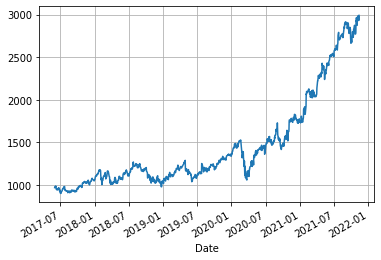

In [ ]:
start = (2017, 6, 1)  # 2017년 06년 01월 
start = datetime.datetime(*start)  
end = datetime.date.today()   
 
#  TSLA Stock Data
# df = yf.download('TSLA',start,end) 

df = yf.download('GOOG',start,end) 

# PLTR Stock Data
# df = yf.download('PLTR',start="2020-12-01",end='2021-09-25')  

df.Close.plot(grid=True)

In [ ]:
print(df.head(5))
print("-" * 75)
print(df.tail(5))
print("-" * 75)
print(df.info())
print(len(df))

                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2017-06-01  968.950012  971.500000  960.010010  966.950012  966.950012  1410500
2017-06-02  969.460022  975.880005  966.000000  975.599976  975.599976  1751000
2017-06-05  976.549988  986.909973  975.099976  983.679993  983.679993  1252100
2017-06-06  983.159973  988.250000  975.140015  976.570007  976.570007  1814600
2017-06-07  980.000000  983.979980  975.940002  980.940002  980.940002  1453900
---------------------------------------------------------------------------
                   Open         High  ...    Adj Close   Volume
Date                                  ...                      
2021-11-08  3000.000000  3020.689941  ...  2987.030029   919400
2021-11-09  2994.919922  3007.570068  ...  2984.969971   843800
2021-11-10  2960.195068  2974.000000  ...  2932.520020  1135400
2021-11-11  2942.139893  2970.044922  ...  2

In [ ]:
# target value :  Closing price 
# X_total = df.iloc[:,3:4].values
X_train = df.iloc[:800, 3:4].values
X_test = df.iloc[800: , 3:4].values

# df.iloc[:3800,:0]
# print(X_train)

# plt.plot(X_train)

In [ ]:
mm = MinMaxScaler() 

# total_set_sc =  mm.fit_transform(X_total)

training_set_sc = mm.fit_transform(X_train)
test_set_sc = mm.transform(X_test) 
total = len(df)
test_length = 800

def data_creat(Scaler_set,num): 
    X_set,Y_set = [],[]

    for i in range(60,num):
        X_set.append(Scaler_set[i-60:i,0])
        Y_set.append(Scaler_set[i,0])

    X_set,Y_set = np.array(X_set),np.array(Y_set)
    X_set = np.reshape(X_set, (X_set.shape[0], X_set.shape[1], 1)) 

    return X_set,Y_set


X_training_set,Y_training_set = data_creat(training_set_sc,test_length)
X_test_set, Y_test_set = data_creat(test_set_sc,total - test_length )
print(X_training_set[0].shape)
print(Y_training_set.shape)

print(X_training_set.shape)
print(X_test_set.shape)

# plt.plot(Y_test_set)
# train시 tesnsor로 바꾸기 

(60, 1)
(740,)
(740, 60, 1)
(263, 60, 1)


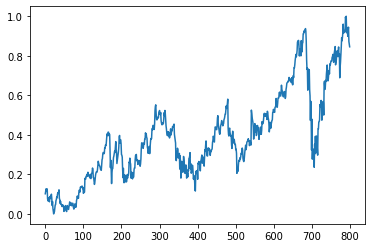

In [ ]:
plt.plot(training_set_sc)

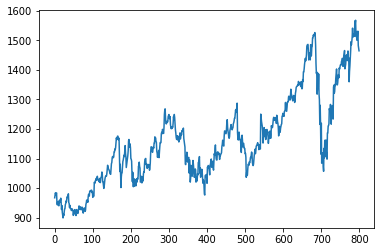

In [ ]:
plt.plot(X_train)

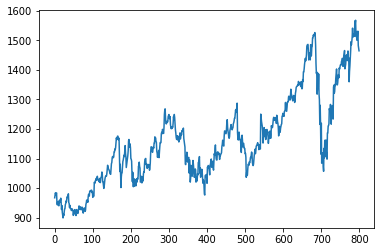

In [ ]:
plt.plot(mm.inverse_transform(training_set_sc))

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10

        # out = self.relu(out)
        # out = self.fc(out)
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())
 
num_epochs = 180
hist = []
val_hist = []

In [ ]:
def train(X_train,Y_train, model, criterion, optimizer):
    model.train()
    X = torch.from_numpy(X_train).float().to(device)
    Y = torch.from_numpy(Y_train).float().to(device)

    # forward
    outputs = model(X)
    loss = criterion(outputs, Y)
    hist.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"#{epoch} ---------------Epoch------------------------") 
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
for epoch in range(num_epochs): 
    # print(f"#{epoch} ---------------Epoch------------------------")
    train(X_training_set,Y_training_set,model,criterion,optimizer) 
    with torch.no_grad():
        out = model(torch.from_numpy(X_test_set).float().to(device))
        loss = criterion(out,torch.from_numpy(Y_test_set).float().to(device))
        val_hist.append(loss.item())
        if epoch % 10 == 0: 
            print("Epoch: %d, val loss: %1.5f" % (epoch, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([740])) that is different to the input size (torch.Size([740, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#0 ---------------Epoch------------------------
Epoch: 0, loss: 0.23966
Epoch: 0, val loss: 5.03269
#10 ---------------Epoch------------------------
Epoch: 10, loss: 0.22524
Epoch: 10, val loss: 4.95407
#20 ---------------Epoch------------------------
Epoch: 20, loss: 0.21135
Epoch: 20, val loss: 4.87520
#30 ---------------Epoch------------------------
Epoch: 30, loss: 0.19791
Epoch: 30, val loss: 4.79510
#40 ---------------Epoch------------------------
Epoch: 40, loss: 0.18483
Epoch: 40, val loss: 4.71299
#50 ---------------Epoch------------------------
Epoch: 50, loss: 0.17197
Epoch: 50, val loss: 4.62801
#60 ---------------Epoch------------------------
Epoch: 60, loss: 0.15922
Epoch: 60, val loss: 4.53910
#70 ---------------Epoch------------------------
Epoch: 70, loss: 0.14648
Epoch: 70, val loss: 4.44498
#80 ---------------Epoch------------------------
Epoch: 80, loss: 0.13369
Epoch: 80, val loss: 4.34420
#90 ---------------Epoch------------------------
Epoch: 90, loss: 0.12083
Ep

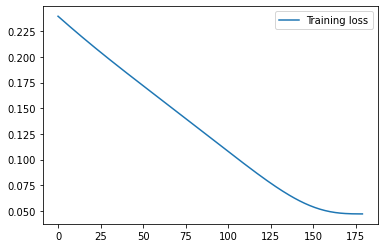

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

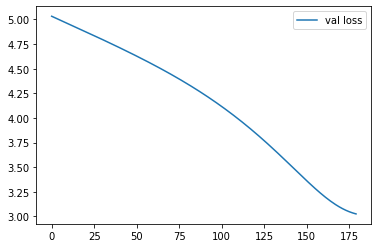

In [ ]:
plt.plot(val_hist, label="val loss")
plt.legend()
plt.show()

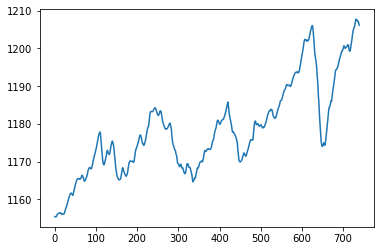

In [ ]:
tx = model(torch.from_numpy(X_training_set).float().to(device))  
plt.plot(mm.inverse_transform(tx.to('cpu').detach().numpy()))

In [ ]:
model.eval()
predicted_stock_price = model(torch.from_numpy(X_test_set).float().to(device))
predicted_stock_price = mm.inverse_transform(predicted_stock_price.to('cpu').detach().numpy())
X = model(torch.from_numpy(X_training_set).float().to(device))    

# predicted_stock_price.shape
# print(X_test.shape)
# print(predicted_stock_price.shape)

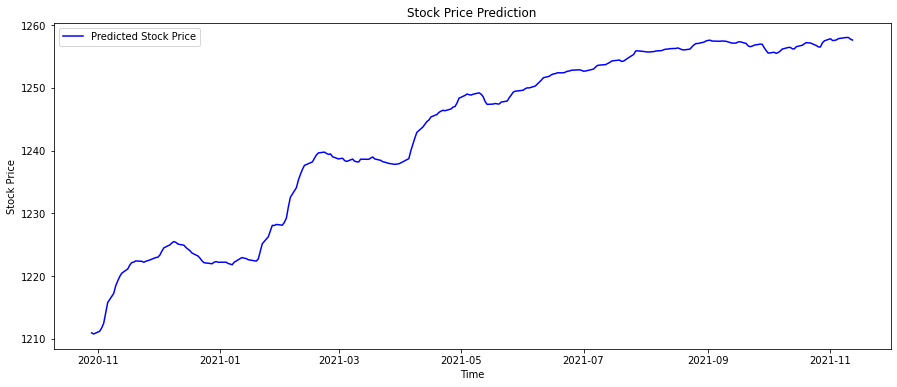

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
# axes.plot(df[len(df)-len(X_test)+60:].index, X_test[60:], color = 'red', label = 'Real Stock Price')
axes.plot(df[len(df)-len(test_set_sc)+60:].index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

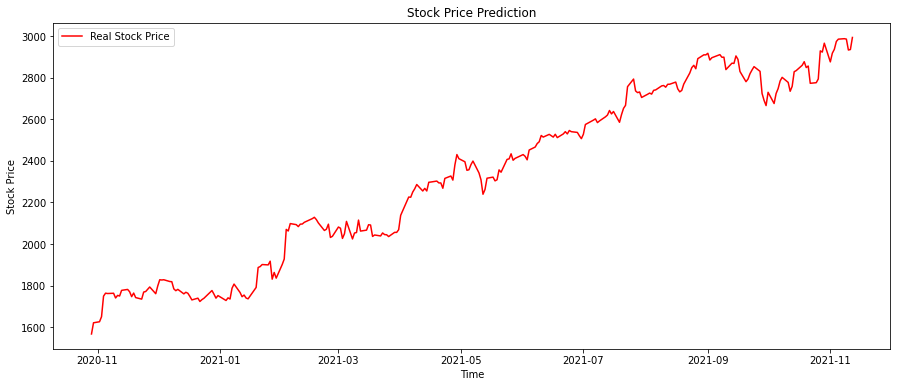

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(df[len(df)-len(X_test)+60:].index, X_test[60:], color = 'red', label = 'Real Stock Price')
# axes.plot(df[len(df)-len(X_test)+60:].index, test_set_sc[60:], color = 'red', label = 'Real Stock Price')
# axes.plot(df[len(df)-len(X_test)+60:].index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()